In [128]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import hvplot.pandas
import plotly.express as px
import re
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, StandardScaler

In [129]:
absenteeism_file = 'Resources/MFGEmployees4.csv'

absenteeism_df = pd.read_csv(absenteeism_file, index_col=False)
absenteeism_df.head()

,EmployeeNumber,Surname,GivenName,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours,BusinessUnit
0,1,Gutierrez,Molly,F,Burnaby,Baker,Bakery,Burnaby,Stores,32.028816,6.018478,36.577306,Stores
1,2,Hardwick,Stephen,M,Courtenay,Baker,Bakery,Nanaimo,Stores,40.320902,5.532445,30.165072,Stores
2,3,Delgado,Chester,M,Richmond,Baker,Bakery,Richmond,Stores,48.822047,4.389973,83.807798,Stores
3,4,Simon,Irene,F,Victoria,Baker,Bakery,Victoria,Stores,44.599357,3.081736,70.020165,Stores
4,5,Delvalle,Edward,M,New Westminster,Baker,Bakery,New Westminster,Stores,35.697876,3.619091,0.000000,Stores


In [130]:
absenteeism_df = pd.read_csv(absenteeism_file, index_col=False)

# Dropping rows with null values
absenteeism_df.dropna()

# Age is rounded down to reflect how people self-report age
absenteeism_df["Age"] = absenteeism_df["Age"].apply(np.floor)

# Drop unneeded columns for ML
absenteeism_df = absenteeism_df.drop(["Surname", "GivenName", "City", "BusinessUnit"], axis=1)

# Length Service is presumed to be in Years
# Rounding LengthService and AbsentHours to two decimals to be more accurate rep of time 
absenteeism_df["LengthService"] = absenteeism_df["LengthService"].round(decimals=2)
absenteeism_df["AbsentHours"] = absenteeism_df["AbsentHours"].round(decimals=2)

# Removing Employees that have no absent hours
absenteeism_df=absenteeism_df.loc[absenteeism_df['AbsentHours']>0]

# Removing Employees that have just started
absenteeism_df=absenteeism_df.loc[absenteeism_df['LengthService']>0]

# Set EmployeeNumber as Index
absenteeism_df.set_index('EmployeeNumber', inplace=True)

### Bin Ages, LengthService, AbsentHours?

absenteeism_df.head(10)

,Gender,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours
EmployeeNumber,,,,,,,,
1,F,Baker,Bakery,Burnaby,Stores,32.0,6.02,36.58
2,M,Baker,Bakery,Nanaimo,Stores,40.0,5.53,30.17
3,M,Baker,Bakery,Richmond,Stores,48.0,4.39,83.81
4,F,Baker,Bakery,Victoria,Stores,44.0,3.08,70.02
6,M,Baker,Bakery,Richmond,Stores,48.0,2.72,81.83
7,M,Accounting Clerk,Accounting,Vancouver,FinanceAndAccounting,50.0,10.16,60.50
8,M,Baker,Bakery,West Vancouver,Stores,36.0,4.43,30.07
9,M,Baker,Bakery,New Westminster,Stores,58.0,6.94,181.63
10,M,Accounting Clerk,Accounting,Vancouver,FinanceAndAccounting,39.0,13.85,30.66


## Unsupervised Machine Learning

In [131]:
def gender_string(gender):
    if gender == 'M':
        return 1
    else:
        return 0

absenteeism_df.update(people_df.loc[:,"Gender"].apply(gender_string))
absenteeism_df.head()

,Gender,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours
EmployeeNumber,,,,,,,,
1,0,Baker,Bakery,Burnaby,Stores,32.0,6.02,36.58
2,1,Baker,Bakery,Nanaimo,Stores,40.0,5.53,30.17
3,1,Baker,Bakery,Richmond,Stores,48.0,4.39,83.81
4,0,Baker,Bakery,Victoria,Stores,44.0,3.08,70.02
6,1,Baker,Bakery,Richmond,Stores,48.0,2.72,81.83


In [132]:
# Bin Titles
absenteeism_df['JobTitle'].value_counts()

Cashier                            1449
Dairy Person                       1289
Meat Cutter                        1239
Baker                              1181
Produce Clerk                       948
Shelf Stocker                       611
Bakery Manager                       36
Store Manager                        31
Meats Manager                        29
Produce Manager                      28
Processed Foods Manager              27
Customer Service Manager             27
Accounting Clerk                     12
Trainer                              11
Auditor                              10
Recruiter                            10
Benefits Admin                       10
Accounts Payable Clerk                9
HRIS Analyst                          9
Labor Relations Analyst               8
Systems Analyst                       7
Accounts Receiveable Clerk            7
Investment Analyst                    4
Compensation Analyst                  4
Corporate Lawyer                      3


In [133]:
# Binning Job Titles for more comprehensive analysis

# Create a function to bin different VP titles
def VP_bin(dataframe):
    
    dataframe['JobTitle'].replace('(\AVP\s.*)', 'VP', regex=True, inplace=True)
        
    return dataframe['JobTitle'].value_counts()

# Create a function to bin different Manager titles
def Mana_bin(dataframe):
    
    dataframe['JobTitle'].replace('(.*\sManager)', 'Manager', regex=True, inplace=True)
        
    return dataframe['JobTitle'].value_counts()

# Create a function to bin different Director titles
def Director_bin(dataframe):
    
    dataframe['JobTitle'].replace('(Director,\s.*)', 'Director', regex=True, inplace=True)
        
    return dataframe['JobTitle'].value_counts()

# Create a function to bin different Exec Assistant titles
def ExecAsst_bin(dataframe):
    
    dataframe['JobTitle'].replace('(Exec\sAssistant,\s.*)', 'Exec Assistant', regex=True, inplace=True)
        
    return dataframe['JobTitle'].value_counts()

# Create a function to bin different Analyst titles
def Analyst_bin(dataframe):
    
    dataframe['JobTitle'].replace('(.*\sAnalyst)', 'Analyst', regex=True, inplace=True)
        
    return dataframe['JobTitle'].value_counts()

# Create a function to bin different Account Clerk titles
def Acct_bin(dataframe):
    
    dataframe['JobTitle'].replace('(Account.*\sClerk)', 'Account Clerk', regex=True, inplace=True)
        
    return dataframe['JobTitle'].value_counts()

In [134]:
VP_bin(absenteeism_df)

Cashier                            1449
Dairy Person                       1289
Meat Cutter                        1239
Baker                              1181
Produce Clerk                       948
Shelf Stocker                       611
Bakery Manager                       36
Store Manager                        31
Meats Manager                        29
Produce Manager                      28
Customer Service Manager             27
Processed Foods Manager              27
Accounting Clerk                     12
Trainer                              11
Benefits Admin                       10
Auditor                              10
Recruiter                            10
Accounts Payable Clerk                9
HRIS Analyst                          9
Labor Relations Analyst               8
Systems Analyst                       7
Accounts Receiveable Clerk            7
Compensation Analyst                  4
Investment Analyst                    4
VP                                    3


In [135]:
Mana_bin(absenteeism_df)

Cashier                            1449
Dairy Person                       1289
Meat Cutter                        1239
Baker                              1181
Produce Clerk                       948
Shelf Stocker                       611
Manager                             179
Accounting Clerk                     12
Trainer                              11
Recruiter                            10
Auditor                              10
Benefits Admin                       10
Accounts Payable Clerk                9
HRIS Analyst                          9
Labor Relations Analyst               8
Systems Analyst                       7
Accounts Receiveable Clerk            7
Investment Analyst                    4
Compensation Analyst                  4
Corporate Lawyer                      3
VP                                    3
Exec Assistant, Human Resources       2
CHief Information Officer             1
Exec Assistant, Legal Counsel         1
Director, Training                    1


In [136]:
Director_bin(absenteeism_df)

Cashier                            1449
Dairy Person                       1289
Meat Cutter                        1239
Baker                              1181
Produce Clerk                       948
Shelf Stocker                       611
Manager                             179
Accounting Clerk                     12
Trainer                              11
Auditor                              10
Benefits Admin                       10
Recruiter                            10
Accounts Payable Clerk                9
HRIS Analyst                          9
Director                              8
Labor Relations Analyst               8
Systems Analyst                       7
Accounts Receiveable Clerk            7
Compensation Analyst                  4
Investment Analyst                    4
VP                                    3
Corporate Lawyer                      3
Exec Assistant, Human Resources       2
Exec Assistant, Legal Counsel         1
CHief Information Officer             1


In [137]:
ExecAsst_bin(absenteeism_df)

Cashier                       1449
Dairy Person                  1289
Meat Cutter                   1239
Baker                         1181
Produce Clerk                  948
Shelf Stocker                  611
Manager                        179
Accounting Clerk                12
Trainer                         11
Auditor                         10
Benefits Admin                  10
Recruiter                       10
HRIS Analyst                     9
Accounts Payable Clerk           9
Labor Relations Analyst          8
Director                         8
Systems Analyst                  7
Accounts Receiveable Clerk       7
Investment Analyst               4
Compensation Analyst             4
VP                               3
Exec Assistant                   3
Corporate Lawyer                 3
CEO                              1
CHief Information Officer        1
Name: JobTitle, dtype: int64

In [138]:
Analyst_bin(absenteeism_df)

Cashier                       1449
Dairy Person                  1289
Meat Cutter                   1239
Baker                         1181
Produce Clerk                  948
Shelf Stocker                  611
Manager                        179
Analyst                         32
Accounting Clerk                12
Trainer                         11
Auditor                         10
Recruiter                       10
Benefits Admin                  10
Accounts Payable Clerk           9
Director                         8
Accounts Receiveable Clerk       7
VP                               3
Exec Assistant                   3
Corporate Lawyer                 3
CEO                              1
CHief Information Officer        1
Name: JobTitle, dtype: int64

In [139]:
absenteeism_df['JobTitle'].value_counts()

Cashier                       1449
Dairy Person                  1289
Meat Cutter                   1239
Baker                         1181
Produce Clerk                  948
Shelf Stocker                  611
Manager                        179
Analyst                         32
Accounting Clerk                12
Trainer                         11
Auditor                         10
Recruiter                       10
Benefits Admin                  10
Accounts Payable Clerk           9
Director                         8
Accounts Receiveable Clerk       7
VP                               3
Exec Assistant                   3
Corporate Lawyer                 3
CEO                              1
CHief Information Officer        1
Name: JobTitle, dtype: int64

In [140]:
# Use get_dummies() to create variables for text features.
X=pd.get_dummies(absenteeism_df, columns=["JobTitle", "DepartmentName", "StoreLocation", "Division"])
print(X.shape)
X.head(10)

(7016, 92)


,Gender,Age,LengthService,AbsentHours,JobTitle_Accounting Clerk,JobTitle_Accounts Payable Clerk,JobTitle_Accounts Receiveable Clerk,JobTitle_Analyst,JobTitle_Auditor,JobTitle_Baker,...,StoreLocation_Victoria,StoreLocation_West Vancouver,StoreLocation_White Rock,StoreLocation_Williams Lake,Division_Executive,Division_FinanceAndAccounting,Division_HumanResources,Division_InfoTech,Division_Legal,Division_Stores
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,0,32.0,6.02,36.58,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1,40.0,5.53,30.17,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,1,48.0,4.39,83.81,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,44.0,3.08,70.02,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
6,1,48.0,2.72,81.83,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
7,1,50.0,10.16,60.50,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,1,36.0,4.43,30.07,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
9,1,58.0,6.94,181.63,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
10,1,39.0,13.85,30.66,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [141]:
# Standardize the data with StandardScaler()
X_scaled=StandardScaler().fit_transform(X)
X_scaled

array([[-1.00171184, -1.4180492 ,  0.59292844, ..., -0.03160247,
        -0.02068277,  0.13191434],
       [ 0.99829108, -0.46702382,  0.36840589, ..., -0.03160247,
        -0.02068277,  0.13191434],
       [ 0.99829108,  0.48400157, -0.15395271, ..., -0.03160247,
        -0.02068277,  0.13191434],
       ...,
       [-1.00171184,  1.6727833 , -0.32807224, ..., -0.03160247,
        -0.02068277,  0.13191434],
       [-1.00171184, -0.1103893 ,  0.65249565, ..., -0.03160247,
        -0.02068277,  0.13191434],
       [ 0.99829108,  0.24624522,  0.20345054, ..., -0.03160247,
        -0.02068277,  0.13191434]])

### K-Means (No PCA)

In [84]:
# Create an elbow curve to find the best value for K.
inertia = []
k = list(range(1,11))
for i in k:
    km = KMeans(n_clusters=i, random_state=5)
    km.fit(X)
    inertia.append(km.inertia_)

elbow_data = {'k' : k, 'inertia' : inertia}
elbow_df = pd.DataFrame(elbow_data)
elbow_df.hvplot.line(x='k', y='inertia', title='Elbow Curve', xticks=k)

:Curve   [k]   (inertia)

In [85]:
# Initialize the K-Means model.
model = KMeans(n_clusters=2, random_state=5)

# Fit the model
model.fit(pcs_df)

# Predict clusters
predictions = model.predict(pcs_df)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [86]:
# Create a new DataFrame including predicted clusters
# Concatentate the absenteeism_df and pcs_df DataFrames on the same columns.

### NO PCA VERSION
clustered_df = pd.concat([absenteeism_df],axis=1)

### ReAdd Employee Names?

#  Add a new column, "Class" to the clustered_df DataFrame that holds the predictions.
clustered_df['Class'] = predictions

# Print the shape of the clustered_df
print(clustered_df.shape)
clustered_df.head(10)

(7016, 9)


,Gender,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours,Class
EmployeeNumber,,,,,,,,,
1,0,Baker,Bakery,Burnaby,Stores,32.0,6.02,36.58,0
2,1,Baker,Bakery,Nanaimo,Stores,40.0,5.53,30.17,0
3,1,Baker,Bakery,Richmond,Stores,48.0,4.39,83.81,0
4,0,Baker,Bakery,Victoria,Stores,44.0,3.08,70.02,0
6,1,Baker,Bakery,Richmond,Stores,48.0,2.72,81.83,0
7,1,Accounting Clerk,Accounting,Vancouver,FinanceAndAccounting,50.0,10.16,60.50,0
8,1,Baker,Bakery,West Vancouver,Stores,36.0,4.43,30.07,0
9,1,Baker,Bakery,New Westminster,Stores,58.0,6.94,181.63,0
10,1,Accounting Clerk,Accounting,Vancouver,FinanceAndAccounting,39.0,13.85,30.66,0


In [87]:
# Create a hvplot.scatter plot using x="Age" and y="AbsentHours".
clustered_df.hvplot.scatter(x='Age', y='AbsentHours', hover_cols='Gender', by='Class')

:NdOverlay   [Class]
   :Scatter   [Age]   (AbsentHours,Gender)

### PCA & K-Means

In [142]:
# Using PCA to reduce dimension to three principal components.
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[-1.90310267e-01, -1.55451031e-02,  2.45623787e-02, ...,
        -5.45122464e-01,  2.59771141e+00,  2.74035740e-02],
       [-2.47489960e-01, -1.34116992e-02,  1.55125990e-02, ...,
        -1.11003337e+00,  2.81164657e+00,  6.42406494e-02],
       [-3.76385210e-01, -2.81641152e-02, -2.57929084e-03, ...,
        -1.21037190e+00,  2.87678309e+00,  4.64436442e-02],
       ...,
       [-3.84303071e-01, -8.82241069e-02, -5.86180210e-02, ...,
         9.90747048e-01, -2.33091718e-02, -9.62523706e-02],
       [ 3.10069161e-01, -2.79934224e-02, -4.71226735e-04, ...,
         2.62713219e+00, -4.57037512e-01, -1.83107138e-02],
       [ 1.71977957e-01, -2.14201606e-02, -9.05470084e-03, ...,
         2.73125411e+00, -3.66598735e-01,  1.78992745e-02]])

In [143]:
# Create a DataFrame with the three principal components.
#pcs_df=pd.DataFrame(data=X_pca, columns=["PC 1", "PC 2"], index = absenteeism_df.index)
#pcs_df=pd.DataFrame(data=X_pca, columns=["PC 1", "PC 2","PC 3","PC 4"], index = absenteeism_df.index)
#pcs_df=pd.DataFrame(data=X_pca, columns=["PC 1", "PC 2","PC 3","PC 4","PC 5"], index = absenteeism_df.index)
#pcs_df=pd.DataFrame(data=X_pca, columns=["PC 1", "PC 2","PC 3","PC 4","PC 5","PC 6","PC 7"], index = absenteeism_df.index)
pcs_df=pd.DataFrame(data=X_pca, columns=["PC 1", "PC 2","PC 3","PC 4","PC 5","PC 6","PC 7","PC 8"], index = absenteeism_df.index)
pcs_df.head(10)

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8
EmployeeNumber,,,,,,,,
1,-0.190310,-0.015545,0.024562,0.011926,-0.893696,-0.545122,2.597711,0.027404
2,-0.247490,-0.013412,0.015513,-0.016219,-0.555391,-1.110033,2.811647,0.064241
3,-0.376385,-0.028164,-0.002579,-0.051527,-0.557889,-1.210372,2.876783,0.046444
4,-0.581034,0.010080,0.002351,0.040436,-0.602130,-1.197182,2.615712,0.033881
6,-0.609618,0.013384,-0.003145,0.007502,-0.554089,-1.215159,2.875145,0.092952
7,14.527709,-1.294828,-0.779453,18.521258,-0.143801,0.296717,0.148095,-0.933692
8,-0.393249,0.020095,0.025010,0.042290,-0.647129,-1.118127,2.833395,0.117671
9,-0.008202,-0.142096,-0.052556,-0.257152,-0.650376,-0.899854,3.028119,-0.144050
10,15.014009,-1.344798,-0.753367,18.465355,-0.210509,0.206461,0.074671,-0.975724


In [144]:
pca.explained_variance_ratio_

array([0.04846893, 0.03273434, 0.03262838, 0.03160465, 0.02760836,
       0.0270063 , 0.02626567, 0.02586922])

In [145]:
### Expanding the number of PCs to 8 still only covers around 25.3% of the data, 
### meaning that K-Means is likely not the best sorting method for this example

In [147]:
# Create an elbow curve to find the best value for K.
inertia = []
k = list(range(1,8))
for i in k:
    km = KMeans(n_clusters=i, random_state=5)
    km.fit(X)
    inertia.append(km.inertia_)

elbow_data = {'k' : k, 'inertia' : inertia}
elbow_df = pd.DataFrame(elbow_data)
elbow_df.hvplot.line(x='k', y='inertia', title='Elbow Curve', xticks=k)

:Curve   [k]   (inertia)

In [58]:
# Initialize the K-Means model.
model = KMeans(n_clusters=2, random_state=5)

# Fit the model
model.fit(pcs_df)

# Predict clusters
predictions = model.predict(pcs_df)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [59]:
# Create a new DataFrame including predicted clusters
# Concatentate the crypto_df and pcs_df DataFrames on the same columns.

### PCA VERSION
clustered_df = pd.concat([absenteeism_df,pcs_df],axis=1)

### ReAdd Employee Names?

#  Add a new column, "Class" to the clustered_df DataFrame that holds the predictions.
clustered_df['Class'] = predictions

# Print the shape of the clustered_df
print(clustered_df.shape)
clustered_df.head(10)

(7016, 13)


,Gender,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours,PC 1,PC 2,PC 3,PC 4,Class
EmployeeNumber,,,,,,,,,,,,,
1,0,Baker,Bakery,Burnaby,Stores,32.0,6.02,36.58,-0.190337,-0.041699,-0.024550,0.054828,0
2,1,Baker,Bakery,Nanaimo,Stores,40.0,5.53,30.17,-0.247749,-0.041133,-0.027276,0.057854,0
3,1,Baker,Bakery,Richmond,Stores,48.0,4.39,83.81,-0.375751,-0.087137,-0.020715,0.108515,0
4,0,Baker,Bakery,Victoria,Stores,44.0,3.08,70.02,-0.581986,0.003022,-0.005669,0.095263,0
6,1,Baker,Bakery,Richmond,Stores,48.0,2.72,81.83,-0.610473,-0.009660,-0.013250,0.104802,0
7,1,Accounting Clerk,Accounting,Vancouver,FinanceAndAccounting,50.0,10.16,60.50,14.356153,14.015341,-7.519372,4.619862,0
8,1,Baker,Bakery,West Vancouver,Stores,36.0,4.43,30.07,-0.394851,0.029971,-0.027396,0.045742,0
9,1,Baker,Bakery,New Westminster,Stores,58.0,6.94,181.63,-0.002112,-0.338001,-0.033391,0.186899,0
10,1,Accounting Clerk,Accounting,Vancouver,FinanceAndAccounting,39.0,13.85,30.66,14.843909,13.937219,-7.534632,4.580202,0


In [60]:
# Creating a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(clustered_df, 
                    x="Gender", y="LengthService", z="Age", 
                    color="Class", symbol="Class", 
                    hover_name="JobTitle", hover_data=["AbsentHours"],width=800)

fig.update_layout(legend=dict(x=0,y=1))
fig.show()

In [61]:
# Create a hvplot.scatter plot using x="TotalCoinsMined" and y="TotalCoinSupply".
clustered_df.hvplot.scatter(x='Age', y='AbsentHours', hover_cols='Gender', by='Class')

:NdOverlay   [Class]
   :Scatter   [Age]   (AbsentHours,Gender)

In [62]:
# Create a hvplot.scatter plot using x="TotalCoinsMined" and y="TotalCoinSupply".
clustered_df.hvplot.scatter(x='Gender', y='AbsentHours', hover_cols='Age', by='Class')

:NdOverlay   [Class]
   :Scatter   [Gender]   (AbsentHours,Age)

## Unsupervised Machine Learning: Hierarchical Clusters

In [63]:
# Normalize the data
normalized = normalize(X)

In [64]:
# Create a new dataframe with the normalized data
normal_df = pd.DataFrame(normalized)
normal_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
0,0.000000,0.652879,0.122823,0.746323,0.0,0.0,0.0,0.0,0.020402,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020402
1,0.019819,0.792770,0.109600,0.597947,0.0,0.0,0.0,0.0,0.019819,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019819
2,0.010340,0.496341,0.045395,0.866632,0.0,0.0,0.0,0.0,0.010340,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010340
3,0.000000,0.531539,0.037208,0.845871,0.0,0.0,0.0,0.0,0.012080,0.0,...,0.01208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012080
4,0.010534,0.505612,0.028651,0.861963,0.0,0.0,0.0,0.0,0.010534,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010534


In [65]:
# Copy column names over to new data frame
normal_df.columns = X.columns
normal_df

,Gender,Age,LengthService,AbsentHours,JobTitle_Accounting Clerk,JobTitle_Accounts Payable Clerk,JobTitle_Accounts Receiveable Clerk,JobTitle_Auditor,JobTitle_Baker,JobTitle_Bakery Manager,...,StoreLocation_Victoria,StoreLocation_West Vancouver,StoreLocation_White Rock,StoreLocation_Williams Lake,Division_Executive,Division_FinanceAndAccounting,Division_HumanResources,Division_InfoTech,Division_Legal,Division_Stores
0,0.000000,0.652879,0.122823,0.746323,0.0,0.0,0.0,0.0,0.020402,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020402
1,0.019819,0.792770,0.109600,0.597947,0.0,0.0,0.0,0.0,0.019819,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019819
2,0.010340,0.496341,0.045395,0.866632,0.0,0.0,0.0,0.0,0.010340,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010340
3,0.000000,0.531539,0.037208,0.845871,0.0,0.0,0.0,0.0,0.012080,0.0,...,0.01208,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012080
4,0.010534,0.505612,0.028651,0.861963,0.0,0.0,0.0,0.0,0.010534,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7011,0.000000,0.290524,0.049389,0.955509,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006316
7012,0.000000,0.440247,0.046322,0.896477,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009571
7013,0.000000,0.312321,0.021593,0.949670,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.00000,0.005385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005385
7014,0.000000,0.578272,0.082706,0.811195,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013448


In [66]:
# Perform hierarchical clustering
mergings = linkage(normalized, method='ward')

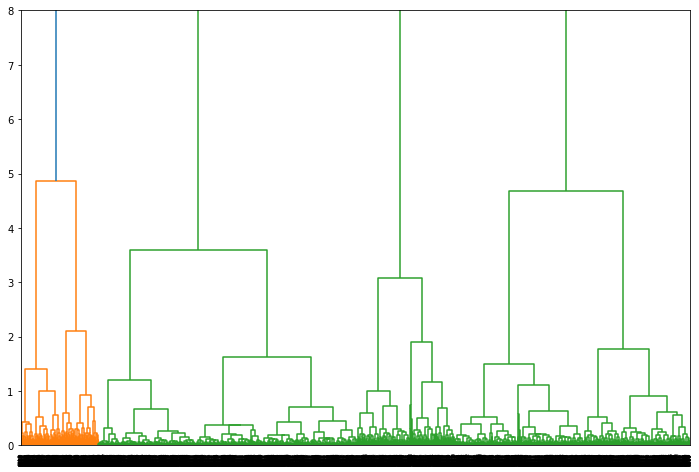

In [67]:
# Generate a dendrogram
plt.figure(figsize=(12,8))

dendrogram(mergings,
          leaf_rotation=90,
          leaf_font_size=5)
plt.ylim(0,8)
plt.show()

In [68]:
# Generate cluster labels with sklearn.cluster's AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=4,
                                 affinity='euclidean',
                                 linkage='ward')
labels = cluster.fit_predict(normal_df)

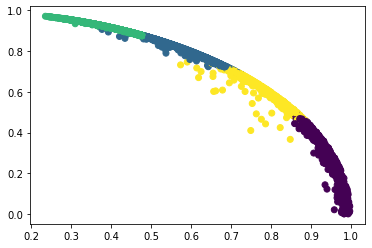

In [69]:
# Create a scatter plot with two of the features
plt.scatter(normal_df['Age'], normal_df['AbsentHours'], c=labels)
plt.show()

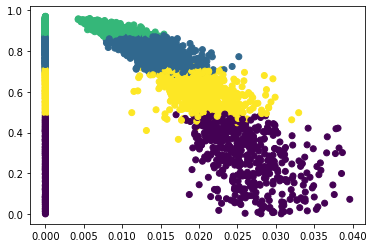

In [70]:
# Create a scatter plot with two of the features
plt.scatter(normal_df['Gender'], normal_df['AbsentHours'], c=labels)
plt.show()